In [2]:
from pathlib import Path
import pandas  as pd
import xarray as xr
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from shapely.geometry import Point, Polygon, MultiPolygon
import shapely.plotting
import geojson
from dask.diagnostics import ProgressBar

import cartopy.crs as ccrs
import cartopy.feature as cfeature


ProgressBar().register()

In [62]:
start_date = "2022-02-01"
end_date = "2024-04-08"
list_date = pd.date_range(start=start_date, end=end_date, freq="D")
list_date = list_date.strftime("%Y-%m-%d")
cases = ["00H12H", "13H24H", ]  #"25H36H", "37H48H", "49H60H", "61H72H", "73H84H", "85H96H", "97H102H"]
filename_to_save_template = "/shared/home/antoine-2etavant/data/arpege/{date}_SP1_{case}.grib2"
filename = filename_to_save_template.format(date=list_date[-1], case=cases[1])

number_of_files_to_process = -1
filenames_morning = [filename_to_save_template.format(date=date, case=cases[0]) for date in list_date[:number_of_files_to_process]]
filenames_afternoon = [filename_to_save_template.format(date=date, case=cases[1]) for date in list_date[:number_of_files_to_process]]

filenames_morning_exist = [filename for filename in filenames_morning if Path(filename).exists()]
filenames_afternoon_exist = [filename for filename in filenames_afternoon if Path(filename).exists()]

filenames_morning = filenames_morning_exist
filenames_afternoon = filenames_afternoon_exist

try:
    ## remove a file that is not working properly
    filenames_afternoon.remove("/shared/home/antoine-2etavant/data/arpege/2023-08-20_SP1_13H24H.grib2")
except:
    pass

save_parquet = number_of_files_to_process == -1


# Open a list a Grib files

The following section opens a list of grib files and merge them intoo one XArray.

It requieres to av install Dask and CFGrid in addition to xarray, that can be install with
```bash
mamba install -y -c conda-forge dask xarray cfgrib
```

In [63]:
KEYS_FILTER_SSPD = { "typeOfLevel" : "surface", "cfVarName": "ssrd", }
KEYS_FILTER_WIND = { "typeOfLevel" : "heightAboveGround", "level": 10, "cfVarName": "si10", }
KEYS_FILTER_T2M = { "typeOfLevel" : "heightAboveGround", 'level': 2, "cfVarName": "t2m", }

number of polygons: 2


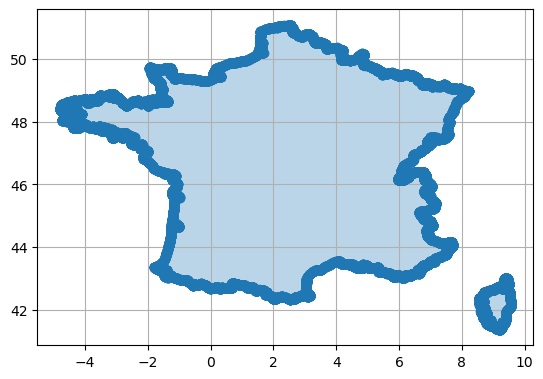

In [64]:

# create mask if point inside metropole
metropole_geojson_file = "../datascience/metropole.geojson"
metropole = geojson.load(open(metropole_geojson_file))
polys_france = [Polygon(geo[0]) for geo in metropole["geometry"]["coordinates"]]
areas = [p.area for p in polys_france]

min_area = 0.2  # threshold to remove small islands
polys_france = [p for p, area in zip(polys_france, areas) if area > min_area]
print(f"number of polygons: {len(polys_france)}")
poly_france = MultiPolygon(polys_france)
#poly_france = polys_france[0]  # france metropolitan

bouns = poly_france.envelope.bounds
min_lon = bouns[0]
max_lon = bouns[2]
min_lat = bouns[1]
max_lat = bouns[3]

for poly in poly_france.geoms:
    shapely.plotting.plot_polygon(poly)

## The Solar Flux

This section reads the solar flux from the GRIB2 files, an uses XArray to process the means.

In [65]:
def drop_no_step(ds):
    # Check if 'step' is in the dataset's coordinates
    # Used to find files that are not working properly
    if 'step' not in ds.coords:
        display(ds)
    return ds

da_ssrd = xr.open_mfdataset(filenames_afternoon,
                       engine="cfgrib",
                       parallel=True,
                       backend_kwargs={'filter_by_keys':KEYS_FILTER_SSPD
                        },
                       concat_dim="time",
                       combine="nested",
                       preprocess=drop_no_step,
                     ).ssrd


[########################################] | 100% Completed | 8.50 ss
[########################################] | 100% Completed | 8.59 s
[########################################] | 100% Completed | 103.28 ms
[########################################] | 100% Completed | 201.11 ms
[########################################] | 100% Completed | 101.67 ms
[########################################] | 100% Completed | 201.42 ms


In [66]:
ssrd_france_large = da_ssrd.sel(step= np.timedelta64(1, "D")
                   ).where((da_ssrd.longitude > min_lon) & (da_ssrd.longitude < max_lon) & (da_ssrd.latitude > min_lat) & (da_ssrd.latitude < max_lat), drop=True)
ssrd_france_large

<xarray.DataArray 'ssrd' (time: 770, latitude: 97, longitude: 143)> Size: 43MB
dask.array<where, shape=(770, 97, 143), dtype=float32, chunksize=(1, 97, 143), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 6kB 2022-02-01 2022-02-02 ... 2024-04-07
    step        timedelta64[ns] 8B 1 days
    surface     float64 8B 0.0
  * latitude    (latitude) float64 776B 51.0 50.9 50.8 50.7 ... 41.6 41.5 41.4
  * longitude   (longitude) float64 1kB -4.7 -4.6 -4.5 -4.4 ... 9.2 9.3 9.4 9.5
    valid_time  (time) datetime64[ns] 6kB dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/29)
    GRIB_paramId:                             169
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_name:                                Surface short-wave (solar) radi...
    GRIB_shortName:                           ssrd
    GRIB_units:                               J m**-2
    long_name:                                Surface short-wave (solar) radi...
    units:                                    J m**-2
    standard_name:                            surface_downwelling_shortwave_f...

In [67]:
total_sun_flux_large = ssrd_france_large.sum(dim=["latitude", "longitude"])
total_sun_flux_large

<xarray.DataArray 'ssrd' (time: 770)> Size: 3kB
dask.array<sum-aggregate, shape=(770,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 6kB 2022-02-01 2022-02-02 ... 2024-04-07
    step        timedelta64[ns] 8B 1 days
    surface     float64 8B 0.0
    valid_time  (time) datetime64[ns] 6kB dask.array<chunksize=(1,), meta=np.ndarray>

In [68]:
df_total_sun_flux_large = total_sun_flux_large.to_dataframe()[["ssrd"]]
df_total_sun_flux_large

[########################################] | 100% Completed | 1.90 sms
[########################################] | 100% Completed | 2.00 s
[                                        ] | 0% Completed | 34.79 sms

In [ ]:
if save_parquet:
    df_total_sun_flux_large.to_parquet("sun_flux.parquet")

<Axes: xlabel='time'>

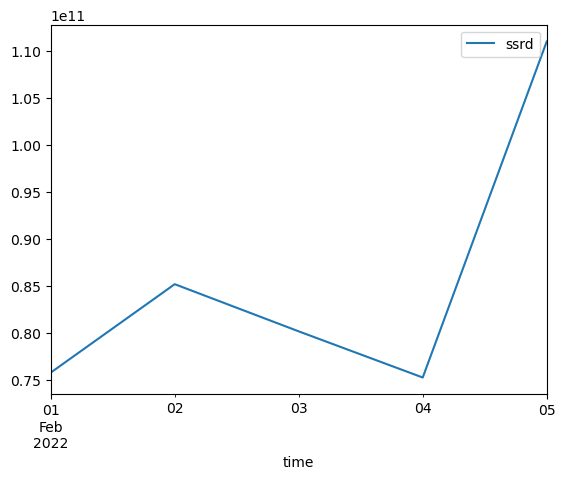

In [ ]:
df_total_sun_flux_large.plot()

## Processing the mean wind speed

In [ ]:
da_wind_10m_morning = xr.open_mfdataset(filenames_morning,
                       engine="cfgrib",
                       parallel=True,
                       backend_kwargs={'filter_by_keys':KEYS_FILTER_WIND},
                       concat_dim="time",
                       combine="nested",
                     ).si10

da_wind_10m_afternoon = xr.open_mfdataset(filenames_afternoon,
                           engine="cfgrib",
                           parallel=True,
                           backend_kwargs={'filter_by_keys':KEYS_FILTER_WIND},
                           concat_dim="time",
                           combine="nested",
                         ).si10
da_wind_10m = xr.concat([da_wind_10m_morning, da_wind_10m_afternoon.where(da_wind_10m_afternoon.step < np.timedelta64(1, "D"), drop=True)], dim="step")
da_wind_10m

[########################################] | 100% Completed | 102.14 ms
[########################################] | 100% Completed | 202.00 ms
[########################################] | 100% Completed | 102.41 ms
[########################################] | 100% Completed | 201.48 ms
[########################################] | 100% Completed | 103.00 ms
[########################################] | 100% Completed | 202.07 ms
[########################################] | 100% Completed | 101.65 ms
[########################################] | 100% Completed | 201.30 ms
[########################################] | 100% Completed | 101.86 ms
[########################################] | 100% Completed | 201.47 ms
[########################################] | 100% Completed | 101.16 ms
[########################################] | 100% Completed | 101.76 ms


<xarray.DataArray 'si10' (time: 5, step: 24, latitude: 521, longitude: 741)> Size: 185MB
dask.array<concatenate, shape=(5, 24, 521, 741), dtype=float32, chunksize=(1, 13, 521, 741), chunktype=numpy.ndarray>
Coordinates:
  * time               (time) datetime64[ns] 40B 2022-02-01 ... 2022-02-05
  * step               (step) timedelta64[ns] 192B 00:00:00 ... 23:00:00
    heightAboveGround  float64 8B 10.0
  * latitude           (latitude) float64 4kB 72.0 71.9 71.8 ... 20.2 20.1 20.0
  * longitude          (longitude) float64 6kB -32.0 -31.9 -31.8 ... 41.9 42.0
    valid_time         (time, step) datetime64[ns] 960B dask.array<chunksize=(1, 13), meta=np.ndarray>
Attributes: (12/29)
    GRIB_paramId:                             207
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                10 metre wind speed
    GRIB_shortName:                           10si
    GRIB_units:                               m s**-1
    long_name:                                10 metre wind speed
    units:                                    m s**-1
    standard_name:                            unknown

In [ ]:
wind_10m_large = da_wind_10m.where((da_wind_10m.longitude > min_lon) & (da_wind_10m.longitude < max_lon) & (da_wind_10m.latitude > min_lat) & (da_wind_10m.latitude < max_lat), drop=True)
wind_10m_large

<xarray.DataArray 'si10' (time: 5, step: 24, latitude: 97, longitude: 143)> Size: 7MB
dask.array<where, shape=(5, 24, 97, 143), dtype=float32, chunksize=(1, 13, 97, 143), chunktype=numpy.ndarray>
Coordinates:
  * time               (time) datetime64[ns] 40B 2022-02-01 ... 2022-02-05
  * step               (step) timedelta64[ns] 192B 00:00:00 ... 23:00:00
    heightAboveGround  float64 8B 10.0
  * latitude           (latitude) float64 776B 51.0 50.9 50.8 ... 41.6 41.5 41.4
  * longitude          (longitude) float64 1kB -4.7 -4.6 -4.5 ... 9.3 9.4 9.5
    valid_time         (time, step) datetime64[ns] 960B dask.array<chunksize=(1, 13), meta=np.ndarray>
Attributes: (12/29)
    GRIB_paramId:                             207
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                10 metre wind speed
    GRIB_shortName:                           10si
    GRIB_units:                               m s**-1
    long_name:                                10 metre wind speed
    units:                                    m s**-1
    standard_name:                            unknown

In [ ]:
total_wind_10m_large = wind_10m_large.sum(dim=["latitude", "longitude"]).stack(time_step=('time', 'step')).set_index(time_step="valid_time")
total_wind_10m_large

[                                        ] | 0% Completed | 142.95 us

[########################################] | 100% Completed | 102.88 ms
[########################################] | 100% Completed | 202.08 ms


<xarray.DataArray 'si10' (time_step: 120)> Size: 480B
dask.array<reshape, shape=(120,), dtype=float32, chunksize=(13,), chunktype=numpy.ndarray>
Coordinates:
    heightAboveGround  float64 8B 10.0
  * time_step          (time_step) datetime64[ns] 960B 2022-02-01 ... 2022-02...
    step               (time_step) timedelta64[ns] 960B 00:00:00 ... 23:00:00
    time               (time_step) datetime64[ns] 960B 2022-02-01 ... 2022-02-05

In [ ]:
df_total_wind_10m_large = total_wind_10m_large.to_dataframe()[["si10"]]

[########################################] | 100% Completed | 34.01 s
[########################################] | 100% Completed | 34.10 s


<Axes: xlabel='time_step'>

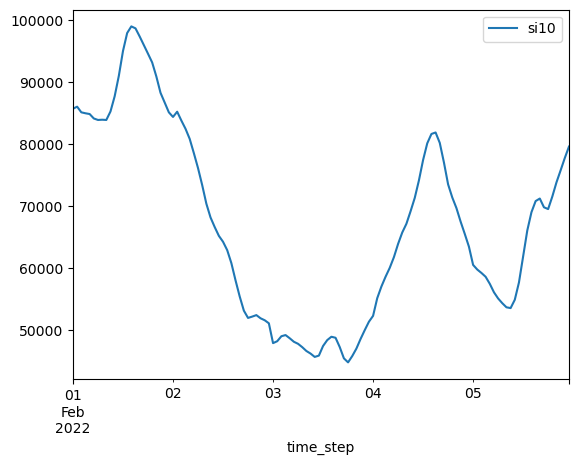

In [ ]:
if save_parquet:
    df_total_wind_10m_large.to_parquet("total_wind_10m.parquet")
df_total_wind_10m_large.plot()

# Aggregating values in the Territory

The Above analysis only looked at the large average / total variable.

The idea of the two next sections is to select only the data inside a given territory

In [27]:
# Define a function that checks if a point is inside the Polygon
def is_inside(lon, lat, polygons: MultiPolygon):
    return polygons.contains(Point(lon, lat))

def compute_mask_da(da: xr.DataArray, polygons: MultiPolygon):
    mask = xr.apply_ufunc(is_inside,
                    da.longitude,
                    da.latitude,
                    kwargs={'polygons': polygons},
                    vectorize=True,
                    dask='parallelized',
                    )
    return mask


In [28]:
mask_france_wind = compute_mask_da(wind_10m_large, poly_france)

Text(0.5, 1.0, 'Mask of France used for Excat mask')

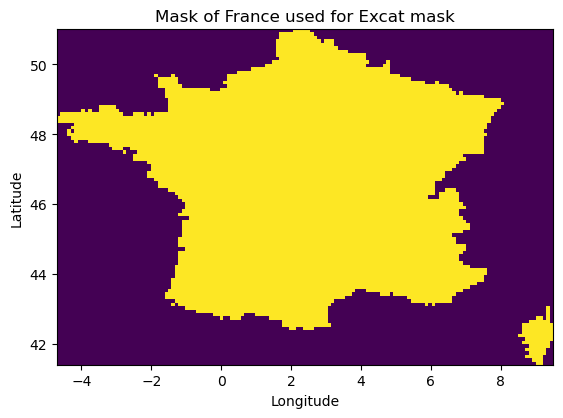

In [29]:
fig, ax = plt.subplots()
im = ax.imshow(mask_france_wind.values.T,
          extent=[mask_france_wind.longitude.min(), mask_france_wind.longitude.max(), mask_france_wind.latitude.min(), mask_france_wind.latitude.max()    ],
          origin="upper")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Mask of France used for Excat mask")

In [ ]:
# Use the mask to select the points from the dataset
wind_10m_exact = wind_10m_large.where(mask_france_wind, drop=True)
wind_10m_exact

<xarray.DataArray 'si10' (time: 5, step: 24, latitude: 97, longitude: 139)> Size: 6MB
dask.array<where, shape=(5, 24, 97, 139), dtype=float32, chunksize=(1, 13, 97, 139), chunktype=numpy.ndarray>
Coordinates:
  * time               (time) datetime64[ns] 40B 2022-02-01 ... 2022-02-05
  * step               (step) timedelta64[ns] 192B 00:00:00 ... 23:00:00
    heightAboveGround  float64 8B 10.0
  * latitude           (latitude) float64 776B 51.0 50.9 50.8 ... 41.6 41.5 41.4
  * longitude          (longitude) float64 1kB -4.7 -4.6 -4.5 ... 9.3 9.4 9.5
    valid_time         (time, step) datetime64[ns] 960B dask.array<chunksize=(1, 13), meta=np.ndarray>
Attributes: (12/29)
    GRIB_paramId:                             207
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                10 metre wind speed
    GRIB_shortName:                           10si
    GRIB_units:                               m s**-1
    long_name:                                10 metre wind speed
    units:                                    m s**-1
    standard_name:                            unknown

[                                        ] | 0% Completed | 108.84 us

[########################################] | 100% Completed | 3.44 ss
[########################################] | 100% Completed | 3.54 s
[########################################] | 100% Completed | 3.44 ss
[########################################] | 100% Completed | 3.54 s
[########################################] | 100% Completed | 3.76 ss
[########################################] | 100% Completed | 3.86 s


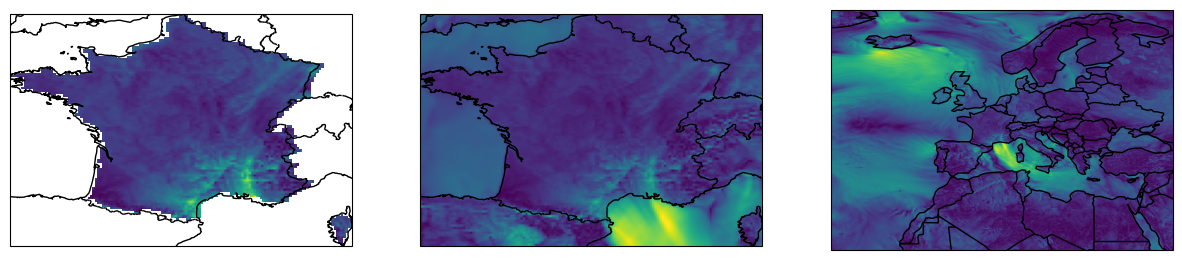

In [ ]:
#plot the first day
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 5),
                                    subplot_kw={'projection': ccrs.PlateCarree()}
)
extent = [min_lon, max_lon, min_lat, max_lat]
ax1.imshow(wind_10m_exact.isel(time=0, step=0), transform=ccrs.PlateCarree(),
              extent=extent,
              origin="upper",
              )

ax2.imshow(wind_10m_large.isel(time=0, step=0),
              transform=ccrs.PlateCarree(),
              extent=extent,
              origin="upper",
              )
ax3.imshow( da_wind_10m.isel(time=0, step=0),
                transform=ccrs.PlateCarree(),
                extent=[da_wind_10m.longitude.min(), da_wind_10m.longitude.max(),
                        da_wind_10m.latitude.min(), da_wind_10m.latitude.max()],
                origin="upper",
                )

for ax in [ax1, ax2, ax3]:
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)

In [ ]:
total_wind_10m_exact = wind_10m_exact.sum(dim=["latitude", "longitude"]).stack(time_step=('time', 'step')).set_index(time_step="valid_time")
total_wind_10m_exact

[########################################] | 100% Completed | 101.53 ms
[########################################] | 100% Completed | 102.45 ms


<xarray.DataArray 'si10' (time_step: 120)> Size: 480B
dask.array<reshape, shape=(120,), dtype=float32, chunksize=(13,), chunktype=numpy.ndarray>
Coordinates:
    heightAboveGround  float64 8B 10.0
  * time_step          (time_step) datetime64[ns] 960B 2022-02-01 ... 2022-02...
    step               (time_step) timedelta64[ns] 960B 00:00:00 ... 23:00:00
    time               (time_step) datetime64[ns] 960B 2022-02-01 ... 2022-02-05

[########################################] | 100% Completed | 33.40 s
[########################################] | 100% Completed | 33.50 s


<Axes: xlabel='time_step'>

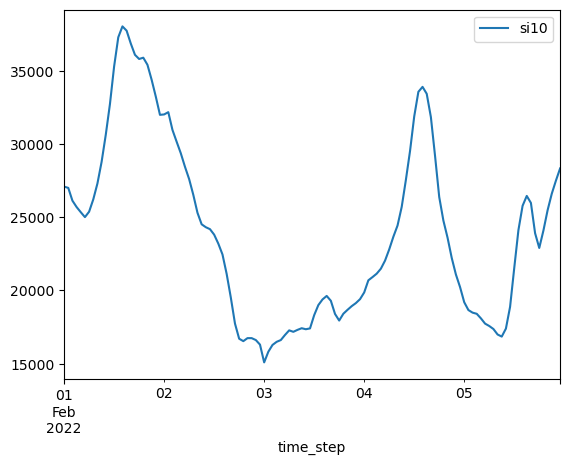

In [ ]:
df_total_wind_10m_exact = total_wind_10m_exact.to_dataframe()[["si10"]]
df_total_wind_10m_exact.plot()

In [ ]:
if save_parquet:
    df_total_wind_10m_exact.to_parquet("total_wind_10m_exact.parquet")

### Now the sun

In [ ]:
ssrd_france_exact = ssrd_france_large.where(mask_france_wind, drop=True)
ssrd_france_exact

<xarray.DataArray 'ssrd' (time: 5, latitude: 97, longitude: 139)> Size: 270kB
dask.array<where, shape=(5, 97, 139), dtype=float32, chunksize=(1, 97, 139), chunktype=numpy.ndarray>
Coordinates:
  * time               (time) datetime64[ns] 40B 2022-02-01 ... 2022-02-05
    step               timedelta64[ns] 8B 1 days
    surface            float64 8B 0.0
  * latitude           (latitude) float64 776B 51.0 50.9 50.8 ... 41.6 41.5 41.4
  * longitude          (longitude) float64 1kB -4.7 -4.6 -4.5 ... 9.3 9.4 9.5
    valid_time         (time) datetime64[ns] 40B dask.array<chunksize=(1,), meta=np.ndarray>
    heightAboveGround  float64 8B 10.0
Attributes: (12/29)
    GRIB_paramId:                             169
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_name:                                Surface short-wave (solar) radi...
    GRIB_shortName:                           ssrd
    GRIB_units:                               J m**-2
    long_name:                                Surface short-wave (solar) radi...
    units:                                    J m**-2
    standard_name:                            surface_downwelling_shortwave_f...

In [ ]:
ssrd_daily_exact = ssrd_france_exact.sum(dim=["latitude", "longitude"])
ssrd_daily_exact

<xarray.DataArray 'ssrd' (time: 5)> Size: 20B
dask.array<sum-aggregate, shape=(5,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time               (time) datetime64[ns] 40B 2022-02-01 ... 2022-02-05
    step               timedelta64[ns] 8B 1 days
    surface            float64 8B 0.0
    valid_time         (time) datetime64[ns] 40B dask.array<chunksize=(1,), meta=np.ndarray>
    heightAboveGround  float64 8B 10.0

In [ ]:
df_ssrd_daily_exact = ssrd_daily_exact.to_dataframe()[["ssrd"]]
df_ssrd_daily_exact

[########################################] | 100% Completed | 101.95 ms
[########################################] | 100% Completed | 202.29 ms
[########################################] | 100% Completed | 19.45 s
[########################################] | 100% Completed | 19.56 s


,ssrd
time,
2022-02-01,2.576592e+10
2022-02-02,2.952812e+10
2022-02-03,3.124386e+10
2022-02-04,2.767228e+10
2022-02-05,5.122384e+10


In [ ]:
if save_parquet:
    ssrd_daily_exact.to_parquet("total_ssrd_daily_exact.parquet")

<Axes: xlabel='time'>

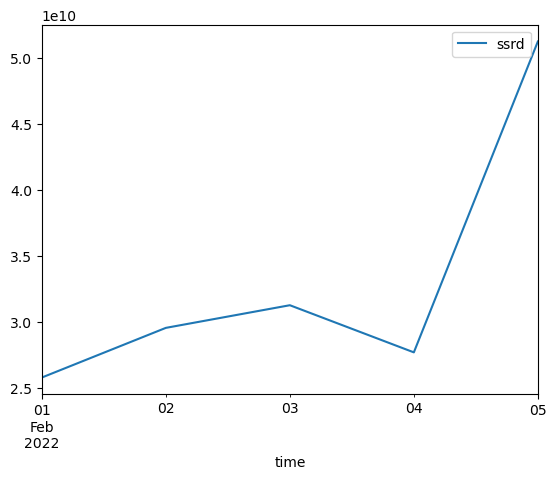

In [ ]:
df_ssrd_daily_exact.plot()

# Each regions

Now, we process each Regions 

In [41]:
filename = "../datascience/regions.geojson"
polys = geojson.load(open(filename))
for feature in polys["features"]:
    print(feature["properties"]["nom"])

Île-de-France
Centre-Val de Loire
Bourgogne-Franche-Comté
Normandie
Hauts-de-France
Grand Est
Pays de la Loire
Bretagne
Nouvelle-Aquitaine
Guadeloupe
Martinique
Guyane
La Réunion
Mayotte
Occitanie
Auvergne-Rhône-Alpes
Provence-Alpes-Côte d'Azur
Corse


  0%|          | 0/18 [00:00<?, ?it/s]

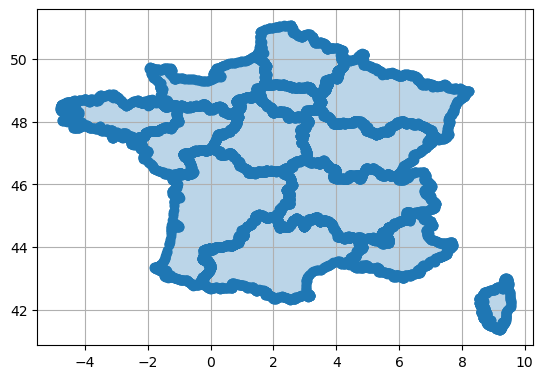

In [42]:
names_to_keep = ["Bretagne",
                 "Centre-Val de Loire",
                 "Grand Est",
                 "Hauts-de-France",
                 "Île-de-France",
                 "Normandie",
                 "Nouvelle-Aquitaine",
                 "Occitanie",
                 "Pays de la Loire",
                 "Provence-Alpes-Côte d'Azur",
                 "Bourgogne-Franche-Comté",
                 "Auvergne-Rhône-Alpes",
                 "Corse"]

polys_region = {}
for feature in tqdm(polys["features"]):
    name = feature["properties"]["nom"]
    if name not in names_to_keep:
        continue
    if feature["geometry"]["type"] == "Polygon":
        polys_region[name] = Polygon(feature["geometry"]["coordinates"][0])
    elif feature["geometry"]["type"] == "MultiPolygon":
        # keeping the largest polygon
        tmp_list = [Polygon(geo[0]) for geo in feature["geometry"]["coordinates"]]
        largest = max(tmp_list, key=lambda x: x.area)
        polys_region[name] = Polygon(largest)


all_polys = [ poly for poly in polys_region.values()]
#unpack the lists
maxi_multi_poly = MultiPolygon(all_polys)
for poly in maxi_multi_poly.geoms:
    shapely.plotting.plot_polygon(poly)

In [45]:
masks = {}
for name, poly in polys_region.items():
    mask = xr.apply_ufunc(is_inside,
                        wind_10m_large.longitude,
                        wind_10m_large.latitude,
                        kwargs={'polygons': poly},
                        vectorize=True,
                        dask='parallelized',
                        )
    masks[name] = mask

Text(0.5, 1.0, 'Masks of the regions')

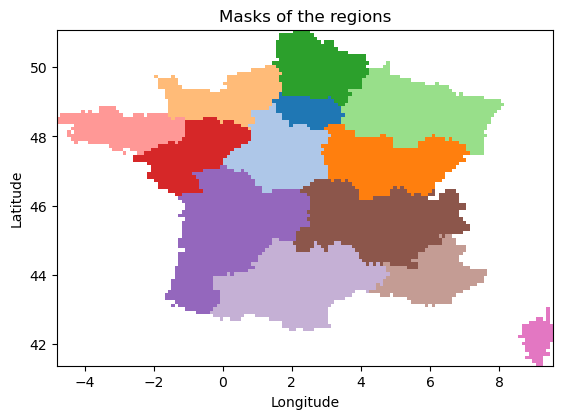

In [59]:
# plot all masks
fig, ax = plt.subplots()
colors = plt.cm.tab20.colors
for c, mask in zip(colors, masks.values()):
    # plot the mask with the color c
    values = mask.values.T.astype(float)
    X = np.array(
        [ [c[0], c[1], c[2], alpha] for alpha in values.flatten() ]
    ).reshape(values.shape + (4,))
    ax.imshow(X,
              origin="upper",
              cmap="viridis",
              extent=extent
    )
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Masks of the regions")

  0%|          | 0/13 [00:00<?, ?it/s]

[########################################] | 100% Completed | 102.19 ms
[########################################] | 100% Completed | 201.79 ms
[########################################] | 100% Completed | 19.64 s
[########################################] | 100% Completed | 19.74 s
[########################################] | 100% Completed | 102.05 ms
[########################################] | 100% Completed | 202.60 ms
[########################################] | 100% Completed | 20.35 s
[########################################] | 100% Completed | 20.45 s
[########################################] | 100% Completed | 101.97 ms
[########################################] | 100% Completed | 201.61 ms
[########################################] | 100% Completed | 21.15 s
[########################################] | 100% Completed | 21.23 s
[########################################] | 100% Completed | 101.64 ms
[########################################] | 100% Completed | 105.80 ms
[###

<Axes: xlabel='time'>

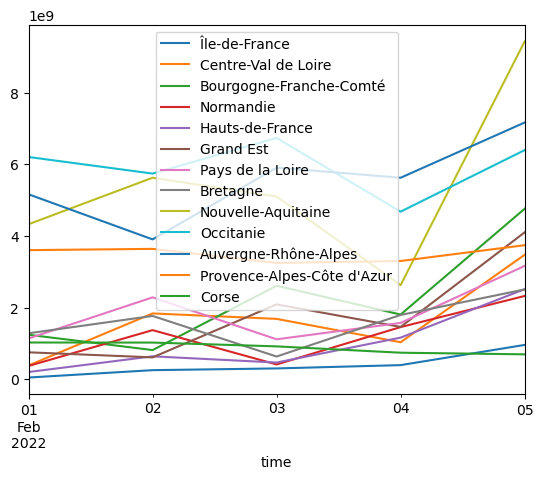

In [ ]:
results_ssrd = {}
for name, mask in tqdm(masks.items()):
    ssrd = ssrd_france_large.where(mask, drop=True)
    ssrd_daily = ssrd.sum(dim=["latitude", "longitude"]).to_dataframe()["ssrd"]
    results_ssrd[name] = ssrd_daily

all_ssrd = pd.concat(results_ssrd, axis=1)
if save_parquet:
    all_ssrd.to_parquet("all_ssrd_regions.parquet")
all_ssrd.plot()

  0%|          | 0/13 [00:00<?, ?it/s]

[                                        ] | 0% Completed | 146.63 us

[########################################] | 100% Completed | 103.18 ms
[########################################] | 100% Completed | 202.04 ms
[########################################] | 100% Completed | 36.61 s
[########################################] | 100% Completed | 36.70 s
[########################################] | 100% Completed | 102.13 ms
[########################################] | 100% Completed | 202.04 ms
[########################################] | 100% Completed | 34.71 s
[########################################] | 100% Completed | 34.81 s
[########################################] | 100% Completed | 101.42 ms
[########################################] | 100% Completed | 200.99 ms
[########################################] | 100% Completed | 36.13 s
[########################################] | 100% Completed | 36.21 s
[########################################] | 100% Completed | 103.07 ms
[########################################] | 100% Completed | 203.37 ms
[###

<Axes: xlabel='time_step'>

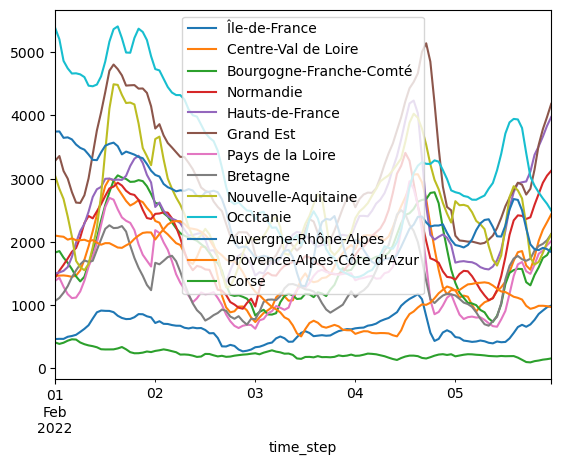

In [ ]:
results_si10 = {}
for name, mask in tqdm(masks.items()):
    wind = wind_10m_large.where(mask, drop=True)
    wind_daily = wind.sum(dim=["latitude", "longitude"]).stack(time_step=('time', 'step')).set_index(time_step="valid_time").to_dataframe()["si10"]
    results_si10[name] = wind_daily

all_si10 = pd.concat(results_si10, axis=1)
if save_parquet:
    all_si10.to_parquet("all_si10_regions.parquet")
all_si10.plot()